In [1]:
%autosave 60

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
! pip install pandarallel
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange
import json
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
tqdm.pandas()
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Autosaving every 60 seconds


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
def get_text_and_score(pathes):
    text_score = []
    for path in pathes:
        file_names = os.listdir(path)
        for file_name in file_names:
            with open(f'{path}/{file_name}', 'r') as file:
                text = file.read()
                score = int(file_name.split('.')[0].split('_')[-1])
            text_score.append([text, score])
    return text_score

In [4]:
path = r'../data/aclImdb'
corpus = get_text_and_score([f'{path}/train/pos/', f'{path}/train/neg/', 
                             f'{path}/test/pos/', f'{path}/test/neg/'])


In [5]:
dataset = pd.DataFrame(corpus, columns=('data', 'target'))

In [6]:
dataset

,data,target
0,This show is a great history story. It's has e...,10
1,"A few years ago, a friend got from one of his ...",10
2,"I like this movie a lot, but it's a fact, that...",10
3,"A brilliant movie about family, guilt, sacrifi...",9
4,One of the many Merrie Melodies cartoons that ...,7
...,...,...
49995,If you are a bit masochistic and like to waste...,1
49996,'R Xmas is one of the only films I've seen whe...,4
49997,Ruggero Deodato is often credited for inventin...,4
49998,"""Stick Around"" is one of the brief series of f...",4


In [7]:
dataset.isnull().sum()

data      0
target    0
dtype: int64

In [8]:
texts_count = 50000
dataset = dataset.iloc[:texts_count]

In [9]:
dataset.dropna(inplace=True)

(array([4.7880e+03, 1.9264e+04, 1.0831e+04, 5.4310e+03, 3.3380e+03,
        2.0760e+03, 1.3850e+03, 9.2400e+02, 6.1200e+02, 4.4900e+02,
        3.2100e+02, 2.6300e+02, 2.4000e+02, 4.8000e+01, 5.0000e+00,
        8.0000e+00, 3.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([   32.        ,   487.73333333,   943.46666667,  1399.2       ,
         1854.93333333,  2310.66666667,  2766.4       ,  3222.13333333,
         3677.86666667,  4133.6       ,  4589.33333333,  5045.06666667,
         5500.8       ,  5956.53333333,  6412.26666667,  6868.        ,
         7323.73333333,  7779.46666667,  8235.2       ,  8690.93333333,
         9146.66666667,  9602.4       , 10058.13333333, 10513.86666667,
        10969.6       , 11425.33333333, 11881.06666667, 12336.8       ,
        12792.53333333, 13248.26666667, 13704.        ]),
 <BarContainer object of 30 

{'whiskers': [<matplotlib.lines.Line2D at 0x7f42b17a71f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f42b17a7730>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f42b17a6ef0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f42b17a7c70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f42b17a7f10>],
 'means': []}

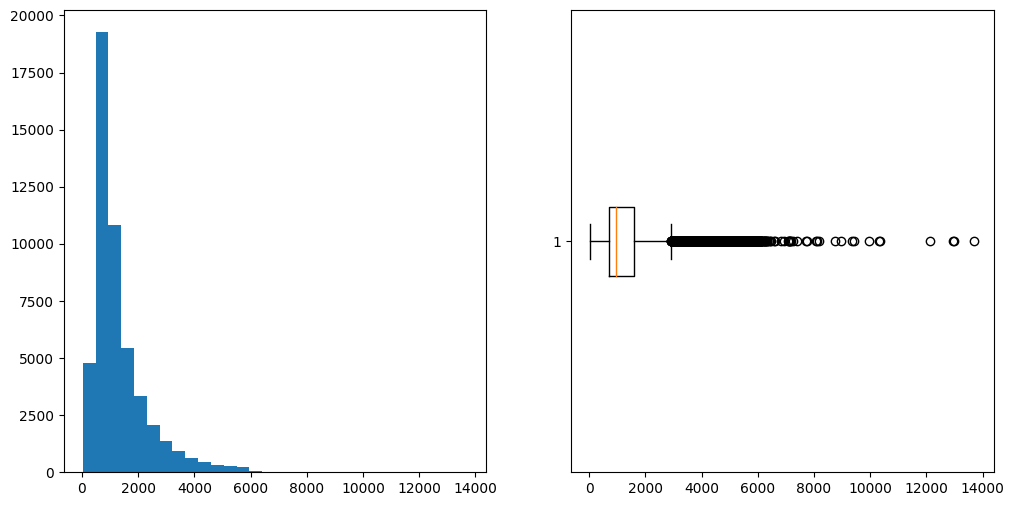

In [10]:
text_lenth = dataset['data'].apply(len)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(text_lenth, 30, label='Гистограмма распределения длин текстов')
axs[1].boxplot(text_lenth, vert=False)

In [11]:
def clean_regex(text):
    text = re.sub('\"{2,3}', '', text)
    text = re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    text = re.sub(r'[.,!?-]', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r' +', ' ', text)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    
    return text

In [3]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.utils import pad_sequences
from collections import Counter
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True, nb_workers = 8)

nltk.download('stopwords')
nltk.download('wordnet')
stopwords = [word for word in set(stopwords.words('english')) if word not in ('no', 'not')]

2023-08-14 22:46:21.944867: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 22:46:22.030270: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 22:46:23.977544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/argen7um/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to /home/argen7um/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
max_lenth = 1500

In [14]:
rex_to_rem_stopwords = '|'.join(f'\s{word}\s' for word in stopwords)

In [15]:
def tokenize_text(text):
    return word_tokenize(text)

def split_words_by_space(text):
    return text.split()

def make_lower(word_list):
    return list(map(lambda t: t.lower(), word_list))

def lemmatize(word_list):
    return list(map(lemmatizer.lemmatize, word_list))

def remove_stop_words1(word_list):
    text = join_word_list(word_list)
    text = re.sub(rex_to_rem_stopwords, ' ', text)
    return split_words_by_space(text)


def add_bos_tag(word_list):
    word_list.insert(0, '<bos>')
    return word_list

def limit_sequence(word_list, max_lenth):
    return word_list[:max_lenth]

def join_word_list(word_list):
    return ' '.join(word_list)

def preprocess_text(text):
    word_list = tokenize_text(text)
    lower_word_list = make_lower(word_list)
    lemmatized_word_list = make_lower(lower_word_list)
    word_list_with_bos = add_bos_tag(remove_stop_words1(lemmatized_word_list))
    preprocessed_text = join_word_list(limit_sequence(word_list_with_bos, 1000))
    
    return preprocessed_text

In [16]:
threshold_count = 15
count_words = Counter(nltk.flatten(list(dataset['data'].parallel_apply(clean_regex).parallel_apply(tokenize_text).parallel_apply(make_lower))))

stopwords = set()
for word in count_words:
    count = count_words[word]
    if count <= threshold_count:
        stopwords.add(word)
        
stopwords = sorted(list(stopwords))
vocabulary = [word for word in count_words if count_words[word] > threshold_count and word not in stopwords]

In [ ]:
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
# %script false
lemmatizer = WordNetLemmatizer()
dataset['cleaned text'] = dataset['data'].parallel_apply(clean_regex)
dataset['preprocessed text'] = dataset['cleaned text'].parallel_apply(preprocess_text)
dataset['preprocessed text']

In [ ]:
# text_lenth = dataset['preprocessed text'].parallel_apply(len)

In [ ]:
dataset

In [ ]:
# %%script false
# dataset.to_csv('processed_data.csv')

In [ ]:
dataset = pd.read_csv('../data/processed_data copy.csv')

In [ ]:
print(dataset.head())

In [ ]:
def get_vocabulary(data_column):
    word_list_column = list(data_column.parallel_apply(split_words_by_space))
    vocabulary = sorted(list(set(nltk.flatten(word_list_column))))
    return vocabulary

In [ ]:
vocabulary = get_vocabulary(dataset['preprocessed text'])

In [4]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.utils import pad_sequences
from collections import Counter
from pandarallel import pandarallel


In [ ]:
def encode_sequence_ngrams(sequense, tokens):
    sequence = split_words_by_space(sequence)


In [ ]:
def word2int(vocabulary):
    word2int_dict = {word : i for i, word in enumerate(vocabulary, 1)}
    int2word_dict = {i : word for word, i in word2int_dict.items()}
    return (word2int_dict, int2word_dict)
        
word2int_dict, int2word_dict = word2int(vocabulary)

In [ ]:
vocabulary

In [ ]:
def encode_sequence(sequence):
    sequence = split_words_by_space(sequence)
    return [word2int_dict[word] for word in sequence]

dataset['encoded sequences'] = dataset['preprocessed text'].parallel_apply(encode_sequence)
dataset['encoded sequences']

In [ ]:
maxlen = max(text_lenth)
dataset['padded sequences'] = list(pad_sequences(dataset['encoded sequences'], max_lenth, padding='pre', value=0))
dataset['padded sequences']

In [ ]:
dataset

In [ ]:
one_hot_vector_lenth = len(vocabulary) + 1
# one_hot_vector_lenth

In [ ]:
def get_one_hot_vector_by_index(index, lenth):
    vector = np.zeros((lenth))
    vector[index] = 1
    return vector

def get_one_hot_vector_by_word(word, lenth):
    index = word2int_dict[word]
    return get_one_hot_vector_by_index(index, lenth)

def get_index_by_one_hot_vector(vector):
    return np.argmax(vector)

def get_word_by_index_one_hot(index):
    return int2word_dict[index]

def encode_secquence_one_hot(sequence):
    return np.array(list(map(lambda a: get_one_hot_vector_by_index(a, one_hot_vector_lenth), sequence)))

In [ ]:
# dataset['one hot'] = dataset['padded sequences'].parallel_apply(encode_secquence_one_hot)
# dataset['one hot']

# WORD2VEC

In [4]:
! pip install torch gensim scikit-learn

In [5]:
dataset = pd.read_csv('../data/ngram_processed_text.csv')
dataset['padded sequences'] = dataset['padded sequences'].parallel_apply(lambda a: list(map(int, a.split(', ')[1:-1])))

In [6]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
corpus = dataset['padded sequences']

In [8]:
embed_dim = 300
w2v_model = Word2Vec(sentences=corpus, vector_size=embed_dim, window=3, min_count=0, workers=4)

In [9]:
length = max(w2v_model.wv.index_to_key) + 2

In [10]:
w2v_matrix = np.zeros((length, embed_dim))
for index, word in enumerate(sorted(w2v_model.wv.index_to_key), 1):
    vec = torch.FloatTensor(w2v_model.wv.get_vector(word)).view((embed_dim))
    print(index)
    w2v_matrix[index] = vec

/tmp/ipykernel_143446/2134534129.py:3: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  vec = torch.FloatTensor(w2v_model.wv.get_vector(word)).view((embed_dim))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [11]:
def split_data(data, labels, test_size=0.2, random_state=None):
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, labels, test_size=test_size, random_state=random_state
    )
    return train_data, test_data, train_labels, test_labels


In [12]:
w2v_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.06684166e-01, -8.35313678e-01,  2.31330711e-02, ...,
        -3.64328861e-01, -5.66906452e-01,  8.40582073e-01],
       [ 9.60470676e-01, -2.45540667e+00, -8.94574404e-01, ...,
        -5.13861597e-01, -2.14990401e+00, -7.51948059e-01],
       ...,
       [-1.14285469e-03,  1.54064607e-03, -2.55074091e-02, ...,
        -1.78441219e-02, -6.22609481e-02,  8.91168863e-02],
       [-1.22656589e-02,  1.58710517e-02, -2.36275769e-03, ...,
        -3.99362221e-02,  1.70616228e-02, -2.16340553e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [13]:
class TextDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        text = self.data[index]
        label = self.labels[index]
        return torch.tensor(text), torch.tensor(label)


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
df = dataset.sample(frac=1)

In [16]:
data = np.array(df['padded sequences'])
labels = np.array(df['target'] > 5).astype(int)

train_data, test_data, train_labels, test_labels = split_data(data[:], labels[:], test_size=0.2, random_state=42)

In [39]:
batch_size = 16
hidden_dim = 200
num_layers = 1
output_labels = 1
n_epochs = 20
learning_rate = 0.001


In [40]:
train_dataset = TextDataset(train_data, train_labels)
test_dataset = TextDataset(test_data, test_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [41]:
class BinaryTextClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, output_labels=1):
        super(BinaryTextClassifier, self).__init__()
        self.embedded = embedding_matrix.shape[1]
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.lstm = nn.LSTM(input_size=self.embedded, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, text):
        embedded = self.embedding(text) 
        lstm_out, _ = self.lstm(embedded)
        lstm_avg = torch.mean(lstm_out, dim=1)
        output = self.fc(lstm_avg).squeeze(1)  # Squeeze to make the shape (batch_size,)

        return output

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BinaryTextClassifier(w2v_matrix, hidden_dim=hidden_dim, num_layers=num_layers, output_labels=output_labels)
model = model.to(device)


criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [43]:
def get_accuracy(preds, labels) -> float:
    preds = (torch.sigmoid(preds) > 0.5).float() 
    accuracy = accuracy_score(labels.cpu(), preds.cpu())
    return accuracy

In [44]:
def train_step(model, texts, labels, optimizer, criterion) -> tuple:
    texts, labels = texts.to(device), labels.to(device)

    optimizer.zero_grad()

    preds = model(texts)
    # print(labels.float())
    # print(preds)
    # print(preds.float())
    # print()
    loss = criterion(preds, labels.float())
    loss.backward()
    acc = get_accuracy(preds, labels)

    optimizer.step()
    return float(loss.cpu().detach().numpy()), float(acc)

In [45]:
def test_step(model, texts, labels, optimizer, criterion) -> tuple:
    texts, labels = texts.to(device), labels.to(device)

    preds = model(texts)
    loss = criterion(preds, labels.float())
    # print(texts)

    acc = get_accuracy(preds, labels)

    return float(loss.cpu().detach().numpy()), float(acc)

In [46]:
def train_epoch(model, optimizer, criterion, data):
    model.train()
    epoch_loss = []
    epoch_acc = []
    
    for texts, labels in data:
        loss, acc = train_step(model, texts.to(device), labels.to(device), optimizer, criterion)
        epoch_loss.append(loss)
        epoch_acc.append(acc)
        train_str = f"Train Loss: {np.mean(epoch_loss):.4f} " +f"Train Accuracy: {np.mean(epoch_acc):.4f}" 
        data.set_description(train_str)
    return epoch_loss, epoch_acc    

In [47]:
def test_epoch(model, optimizer, criterion, data):
    model.eval()
    
    epoch_loss = []
    epoch_acc = []
    
    with torch.no_grad():
        for texts, labels in data:
            loss, acc = test_step(model, texts, labels, optimizer, criterion)
            epoch_loss.append(loss)
            epoch_acc.append(acc)
            train_str = f"Test Loss: {np.mean(epoch_loss):.4f} " +f"Test Accuracy: {np.mean(epoch_acc):.4f}" 
            data.set_description(train_str)
    return epoch_loss, epoch_acc

In [48]:
def loop(model, optimizer, criterion, train_dataloader, test_dataloader, n_epochs):
    train_epoch_losses = []
    test_epoch_losses = []
    train_epoch_acces = []
    test_epoch_acces = []
    
    pbar = trange(n_epochs)
    for epoch in pbar:
        for loader, is_train in zip([train_dataloader, test_dataloader], [True, False]):
            batch_iterator = tqdm(loader, unit="batch", leave=False)
            # исправить обучение я забыл теститрование

            if is_train:
                epoch_loss, epoch_acc = train_epoch(model, optimizer, criterion, batch_iterator)
                
                train_epoch_losses.append(epoch_loss)
                train_epoch_acces.append(epoch_acc)
            else: 
                epoch_loss, epoch_acc = test_epoch(model, optimizer, criterion, batch_iterator)
                test_epoch_losses.append(epoch_loss)
                test_epoch_acces.append(epoch_acc)

#                 )

            train_str = f"Epoch {epoch+1}/{n_epochs} " + f"{'Train' if is_train else 'Test'} Loss: {np.mean(epoch_loss):.4f} " +f"{'Train' if is_train else 'Test'} Accuracy: {np.mean(epoch_acc):.4f}" 
            batch_iterator.set_description(train_str)

            batch_iterator.update()
#               break
        pbar.set_description(train_str)
        pbar.update()
#         break
    history = [
        train_epoch_losses, test_epoch_losses, train_epoch_acces, test_epoch_acces
    ]
    return history   

In [ ]:
history = loop(model, optimizer, criterion, train_dataloader, test_dataloader, n_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

In [ ]:
history

[[[0.6934475898742676,
   0.693587064743042,
   0.6932516098022461,
   0.6916186809539795,
   0.6953433752059937,
   0.6920655369758606,
   0.6957085132598877,
   0.6947088241577148,
   0.6922965049743652,
   0.6911733746528625,
   0.6906981468200684,
   0.6922482252120972,
   0.6909623146057129,
   0.6837862730026245,
   0.6915827393531799,
   0.6978875398635864,
   0.6827329397201538,
   0.7013243436813354,
   0.6932647228240967,
   0.690165638923645,
   0.6807974576950073,
   0.6999266743659973,
   0.6845995187759399,
   0.6868337392807007,
   0.6827717423439026,
   0.6800783276557922,
   0.6904292106628418,
   0.6718181371688843,
   0.6602603197097778,
   0.669001579284668,
   0.6709225177764893,
   0.6480271816253662,
   0.6542825102806091,
   0.6799526214599609,
   0.654685914516449,
   0.6654208302497864,
   0.6587386727333069,
   0.6578969955444336,
   0.7226788997650146,
   0.6918172240257263,
   0.7261236906051636,
   0.6928986310958862,
   0.6905876398086548,
   0.7034653425

In [49]:
for num_layers in [3, 4]:
    for hidden_dim in [200, 500]:
        model = BinaryTextClassifier(w2v_matrix, hidden_dim, num_layers, output_labels=1).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        history = loop(model, optimizer, criterion, train_dataloader, test_dataloader, n_epochs)
        torch.save(model.state_dict(), f'../model/n_grams_test{hidden_dim} {num_layers} {batch_size}.pt')
        
        with open(f'n_grams_history{hidden_dim} {num_layers} {batch_size}.json', 'w', encoding='utf-8') as file:
            json.dump(history, file, ensure_ascii=False, indent=4)
        del model 

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 5.93 GiB total capacity; 278.57 MiB already allocated; 42.81 MiB free; 326.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:

import json
for hidden_dim in [50, 100, 500, 1000]:
    model = BinaryTextClassifier(w2v_matrix, hidden_dim, output_labels).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = loop(model, optimizer, criterion, train_dataloader, test_dataloader, n_epochs)
    torch.save(model.state_dict(), f'../model/test{hidden_dim} 64batch.pt')
    
    with open(f'history{hidden_dim} 64batch.json', 'w', encoding='utf-8') as file:
        json.dump(history, file, ensure_ascii=False, indent=4)
    del model 


In [ ]:
# torch.save(model.state_dict(), '../model/test500.pt')

In [ ]:
def make_plots(histories):
    fig, axss = plt.subplots(2, 2)
    fig.set_size_inches(30, 15)
    for plot_name, history in histories.items():
        for i, ((data1, data2), axs)  in enumerate(zip(list(zip(history, history[1:]))[::2], axss)):
            for data, stage, ax in zip((data1, data2), ('Train', 'Test'), axs):
                data = nltk.flatten([np.mean(i) for i in data])
                ax.plot(data, label=f"{stage} {'loss' if i == 0 else 'acc'} {plot_name}")
                ax.legend()
                ax.grid(which='major', color='#666666', linestyle='-')
                ax.minorticks_on()
                ax.grid( which='minor', color='#999999', linestyle='-', alpha=0.2)
                
        # for i, ((data1, data2), ax)  in enumerate(zip(list(zip(history, history[1:]))[::2], axs[1])):
        #     for data, stage in zip((data1, data2), ('Train', 'Test')):
        #         data = nltk.flatten(data)
        #         ax.plot(data, label=f"{stage} {'loss' if i == 0 else 'acc'}")
        #     ax.legend()

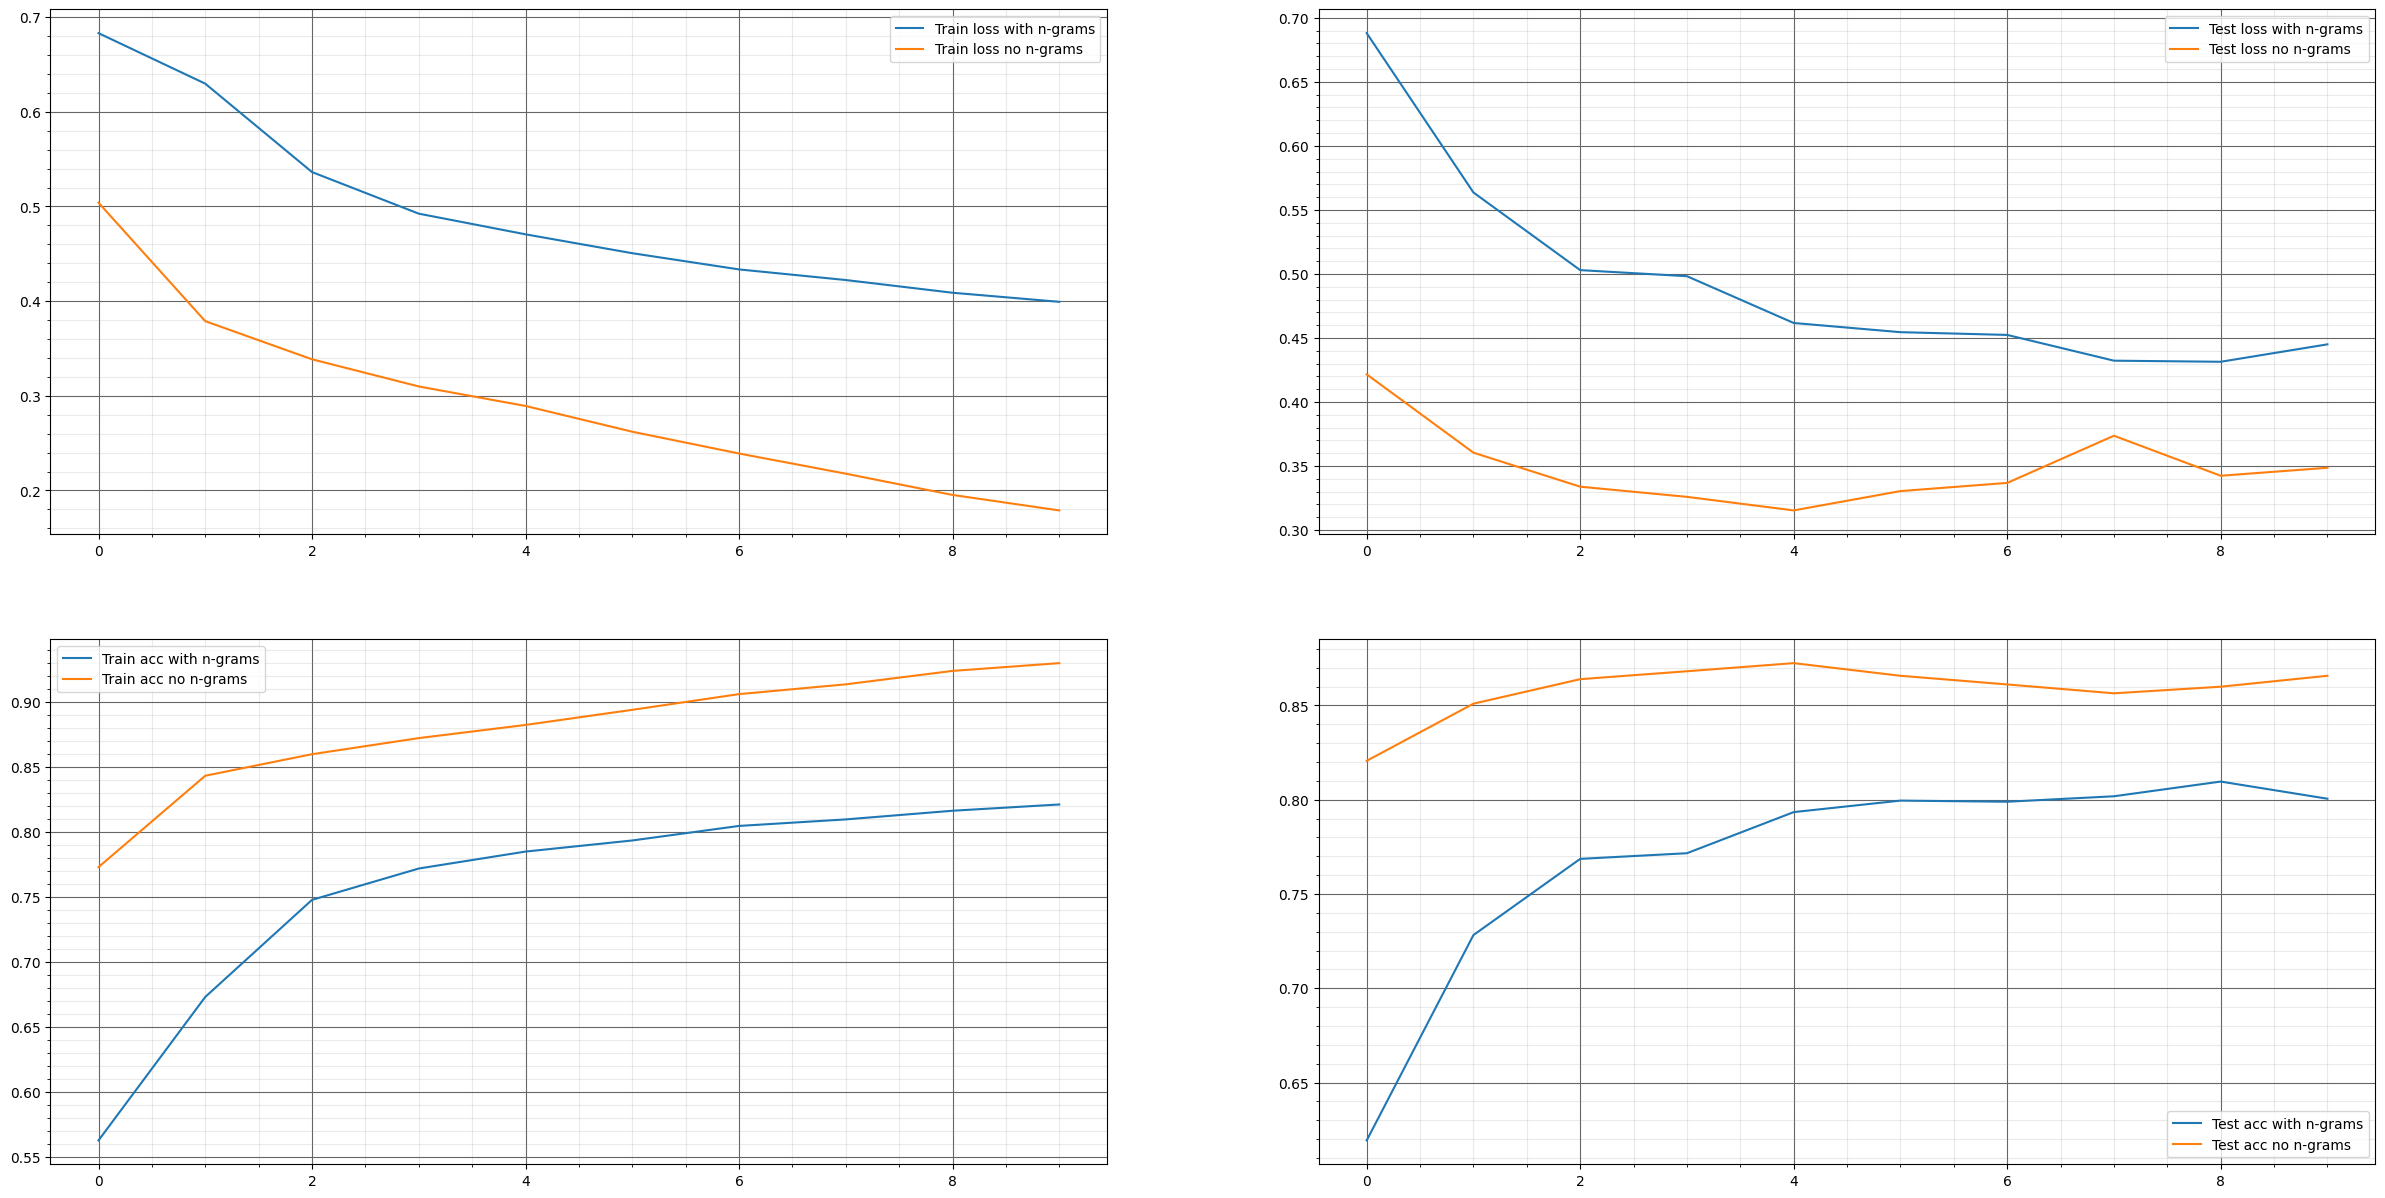

In [ ]:
make_plots({'with n-grams' : history, 'no n-grams' : histories['200 1 32']} )

In [ ]:
histories['200 1 32']

In [ ]:
def import_histories():
    pathes = [path for path in os.listdir() if re.search(r'history\d+ \d+ \d+.json', path) is not None]
    histories = {}
    for path in pathes:
        with open(path, 'r', encoding='utf-8') as file:
            print(path)
            histories[path.replace('history', '').replace('.json', '')] = json.load(file)
    
    return histories

def get_keys_history_by_equal_num(n, l, histories):
    return list(filter(lambda a: int(a.split()[n]) == l, histories))

def get_histories_by_keys(keys, histories):
    return {
        key : value for key, value in histories.items() if key in keys
    }
histories = import_histories()

In [ ]:
histories.keys()

In [ ]:
keys = get_keys_history_by_equal_num(1, 1, histories)
make_plots(get_histories_by_keys(keys, histories))

In [ ]:
keys = get_keys_history_by_equal_num(0, 200, histories)
make_plots(get_histories_by_keys(keys, histories))

In [ ]:
keys = get_keys_history_by_equal_num(1, 1, histories)
make_plots(get_histories_by_keys(keys, histories))

In [ ]:
keys = get_keys_history_by_equal_num(1, 2, histories)
make_plots(get_histories_by_keys(keys, histories))

In [ ]:
keys = get_keys_history_by_equal_num(1, 3, histories)
make_plots(get_histories_by_keys(keys, histories))

In [ ]:
keys = get_keys_history_by_equal_num(1, 4, histories)
make_plots(get_histories_by_keys(keys, histories))

In [ ]:
h = histories
training_results = pd.DataFrame(h, index=[['Train loss', 'Test loss', 'Train acc', 'Test acc']])
new_df = pd.DataFrame()
for i, index in enumerate(training_results.index):
    training_results.iloc[i] = training_results.iloc[i].apply(lambda a: list(np.round(np.mean(a, 1), 4))).apply(nltk.flatten)
    new_df = pd.concat([new_df, pd.DataFrame(training_results.iloc[i].to_dict())])

index = pd.MultiIndex.from_tuples(list(zip(*[['Train loss']*10+['Test loss']*10+\
                                             ['Train acc']*10+['Test acc']*10, list(range(1, 11))*4])))
new_df.index = index


In [ ]:
new_df.head()

In [ ]:
# Минимальный средный лосс по эпохам при обучении с различными параметрами 
new_df.iloc[:20].min(1)['Test loss']

In [ ]:
# Минимальный лосс на тестовой выборке для каждого обучения 
min_loss_in_trainings_in_test = new_df.iloc[10:20].min(0)
print(min_loss_in_trainings_in_test)
print(min_loss_in_trainings_in_test.min())

In [ ]:
new_df.iloc[20:].max(1)